# ЛР 5- Детерминированная сегментация

## Задание
№1
1. Преобразование изображения в оттенки серого
2. Порог Оцу для получения бинарного изображения
3. Вычислите преобразование евклидова расстояния
4. Выполнение анализа подключенных компонентов
5. Применить водораздел
6. Перебор значений меток и извлечение объектов

№2 Выполнить поиск подходящего алгоритма сегментации среди рассмотренных методов с точки зрения метрик для тестового изображения.

In [3]:
import skimage
from skimage import data, restoration, util, img_as_float, filters, color, morphology, segmentation
from skimage.filters import threshold_otsu, try_all_threshold, threshold_niblack, threshold_sauvola, threshold_multiotsu

from skimage.filters import sobel, rank
from skimage.measure import label
from skimage.color import label2rgb

from skimage.segmentation import (chan_vese, morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

from skimage.segmentation import watershed, expand_labels, flood, flood_fill
from skimage.feature import peak_local_max
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

from skimage.feature import canny
from skimage.draw import line
from skimage.util import img_as_ubyte

#from skimage.future.graph import rag
#from skimage.future import graph

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity

from skimage.morphology import erosion, dilation, opening, closing, white_tophat, black_tophat, square
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, thin
from skimage.morphology import disk

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

import networkx as nx
import imageio
import imutils
import cv2

from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import deque
from math import sqrt, exp
import numpy as np
import scipy.ndimage as ndi
import pandas as pd
import math

In [4]:
def show_binary(image, binary):
    fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3)

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    plt.show()

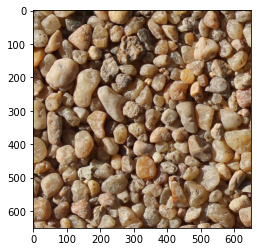

In [5]:
image_orig = plt.imread('img6.jpg')
image_orig = image_orig[:650,:650,:]
plt.imshow(image_orig);

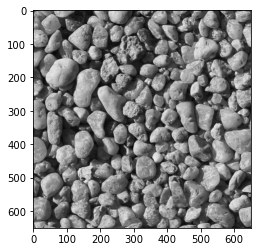

In [6]:
image = color.rgb2gray(image_orig)
plt.imshow(image, 'gray');

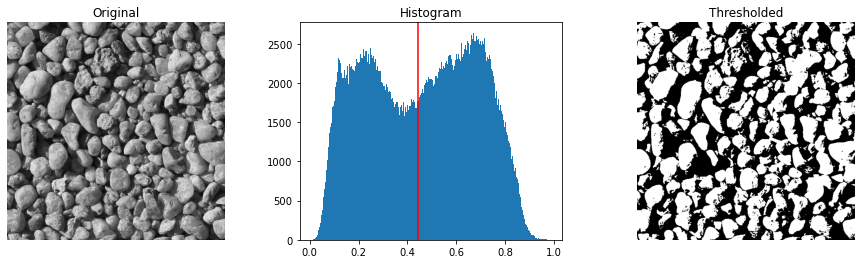

In [7]:
thresh = threshold_otsu(image)
binary = image > thresh

show_binary(image, binary)

Метод морфологической обработки контуров Morphological Snakes

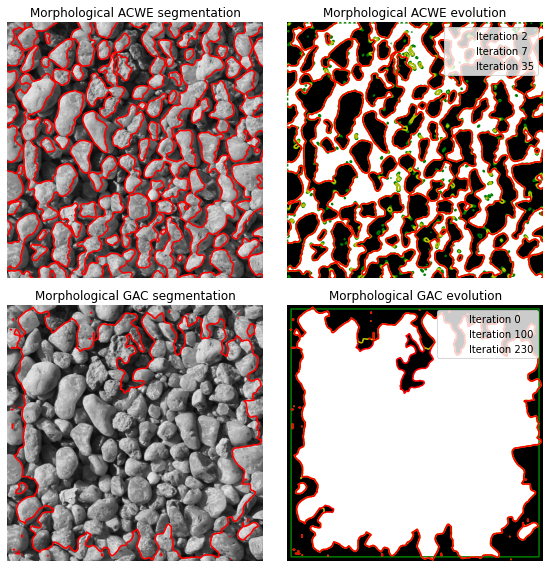

In [8]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)



fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)




gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()


Создание расширенной области вокруг результатов сегментации по водоразделам

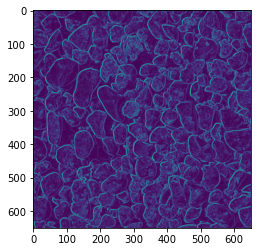

In [9]:
# Make segmentation using edge-detection and watershed.
image = (image * 255).astype(np.uint8)
edges = sobel(image)
plt.imshow(edges);

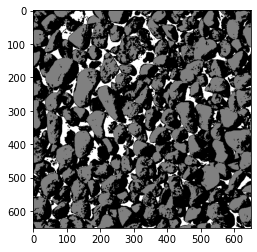

In [10]:
# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(image)
foreground, background = 1, 2
markers[image < 35.0] = background
markers[image > 140.0] = foreground
plt.imshow(markers, cmap='gray');

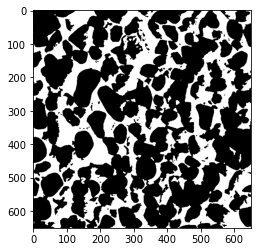

In [11]:
ws = watershed(edges, markers)
plt.imshow(ws, 'gray');

In [12]:
ws[ws == 2] = 0
ws = ws*255
inverted_ws = ws

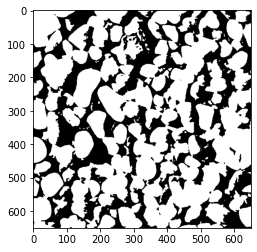

In [13]:
plt.imshow(inverted_ws, 'gray');

In [14]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

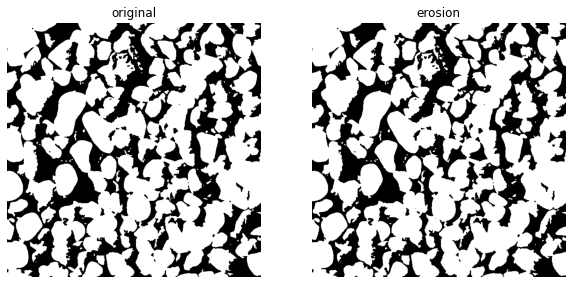

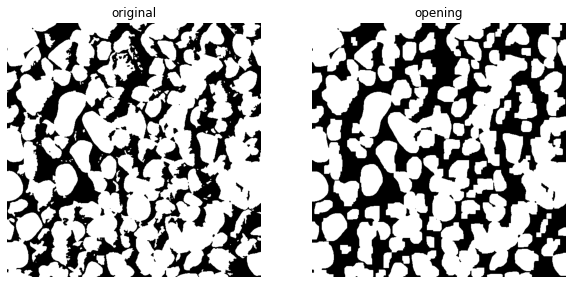

In [16]:
# сначала разъединим объекты
selem = np.ones((1,1),np.uint8)
eroded = erosion(inverted_ws, selem)
plot_comparison(inverted_ws, eroded, 'erosion')

# Теперь уберем выбросы
kernel = np.ones((12,12),np.uint8)
opening_j = cv2.morphologyEx(eroded.astype(np.uint8), cv2.MORPH_OPEN, kernel)

plot_comparison(eroded, opening_j, 'opening')



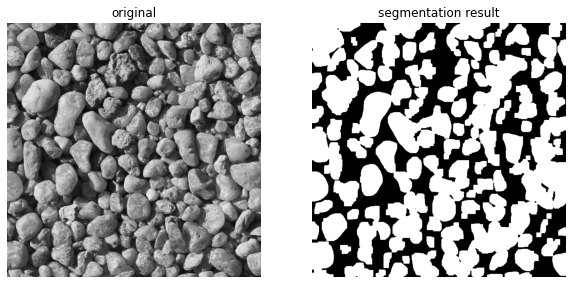

In [17]:
plot_comparison(image, opening_j, 'segmentation result')

In [19]:
ret, markers = cv2.connectedComponents(opening_j)

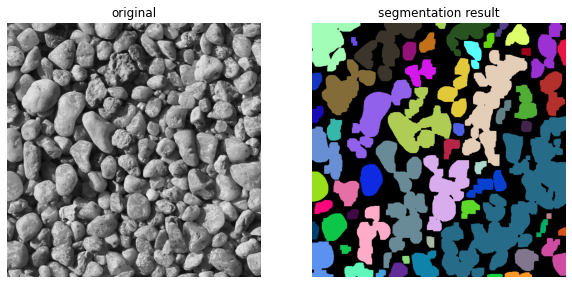

In [20]:
import cv2
import numpy as np
import random

# Генерация случайных цветов для каждой метки объекта
colors = []
for i in range(ret):
    colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

# Нанесение цветов на каждый объект на исходном изображении
output_image = np.zeros_like(image_orig)  

for label in range(1, ret):
    mask = markers == label
    output_image[mask] = colors[label]

plot_comparison(image, output_image, 'segmentation result')


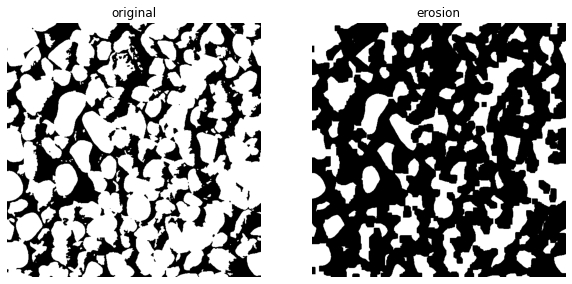

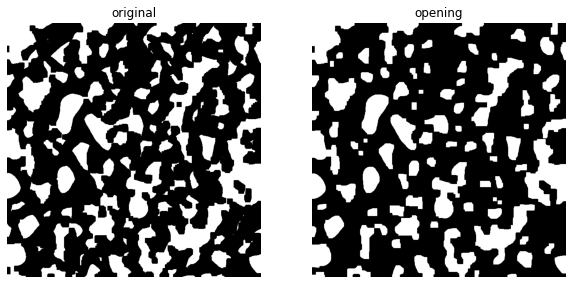

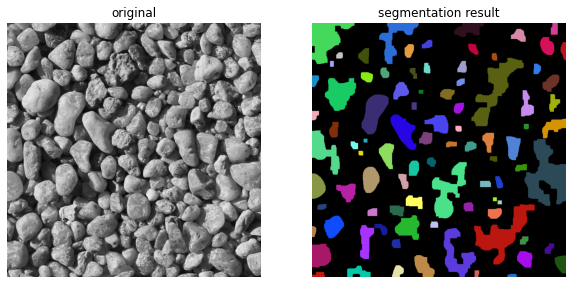

In [22]:
# сначала разъединим объекты
selem = np.ones((12,12),np.uint8)
eroded = erosion(inverted_ws, selem)
plot_comparison(inverted_ws, eroded, 'erosion')

# Теперь уберем выбросы
kernel = np.ones((10,10),np.uint8)
opening_j = cv2.morphologyEx(eroded.astype(np.uint8), cv2.MORPH_OPEN, kernel)

plot_comparison(eroded, opening_j, 'opening')
ret, markers = cv2.connectedComponents(opening_j)

# Генерация случайных цветов для каждой метки объекта
colors = []
for i in range(ret):
    colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

# Нанесение цветов на каждый объект на исходном изображении
output_image = np.zeros_like(image_orig)  

for label in range(1, ret):
    mask = markers == label
    output_image[mask] = colors[label]

# Отображение изображения с цветными объектами
plot_comparison(image, output_image, 'segmentation result')

---